CRIME DATASET

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from random import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

READ DATA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
Data = pd.read_csv('drive/MyDrive/ML2022/sensor_readings_4.csv')
D=Data.to_numpy()
dim=np.shape(D)
print(dim)
DF=np.copy(D)


(5456, 5)


In [43]:
DF = np.where(DF == 'Move-Forward' , 0, DF)
DF = np.where(DF == 'Sharp-Right-Turn', 1, DF)
DF = np.where(DF == 'Slight-Left-Turn' , 2, DF)
DF = np.where(DF == 'Slight-Right-Turn', 3, DF)

EDA

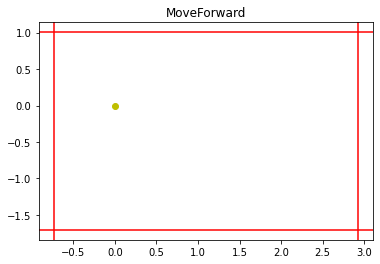

In [21]:
fig, ax = plt.subplots()
found=0
i=0
while found==0:
  if DF[i,4] == 0:
    found=1
    plt.axvline(x=DF[i,2],color='r')
    plt.axvline(x=-DF[i,1],color='r')
    plt.axhline(y=DF[i,0], color='r')
    plt.axhline(y=-DF[i,3], color='r')
    ax.plot(0,0,'yo')
    ax.set_title('MoveForward')
  i=randint(0, np.shape(DF)[0])

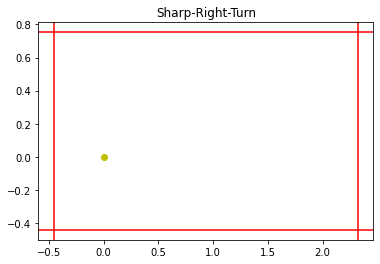

In [17]:
fig, ax = plt.subplots()
found=0
i=0
while found==0:
  if DF[i,4] == 1:
    found=1
    plt.axvline(x=DF[i,2],color='r')
    plt.axvline(x=-DF[i,1],color='r')
    plt.axhline(y=DF[i,0], color='r')
    plt.axhline(y=-DF[i,3], color='r')
    ax.plot(0,0,'yo')
    ax.set_title('Sharp-Right-Turn')
  i=randint(0, np.shape(DF)[0])

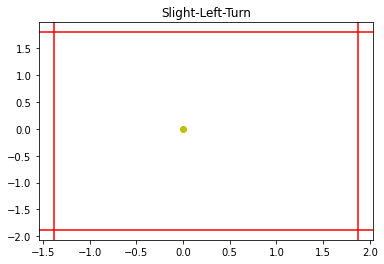

In [26]:
fig, ax = plt.subplots()
found=0
i=0
while found==0:
  if DF[i,4] == 2:
    found=1
    plt.axvline(x=DF[i,2],color='r')
    plt.axvline(x=-DF[i,1],color='r')
    plt.axhline(y=DF[i,0], color='r')
    plt.axhline(y=-DF[i,3], color='r')
    ax.plot(0,0,'yo')
    ax.set_title('Slight-Left-Turn')
  i=randint(0, np.shape(DF)[0])

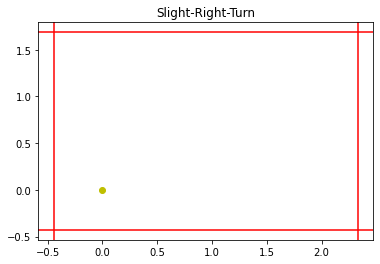

In [25]:
fig, ax = plt.subplots()
found=0
i=0
while found==0:
  if DF[i,4] == 3:
    found=1
    plt.axvline(x=DF[i,2],color='r')
    plt.axvline(x=-DF[i,1],color='r')
    plt.axhline(y=DF[i,0], color='r')
    plt.axhline(y=-DF[i,3], color='r')
    ax.plot(0,0,'yo')
    ax.set_title('Slight-Right-Turn')
  i=randint(0, np.shape(DF)[0])

In [50]:
dim=np.shape(DF)
print(dim)
il=round(0.40*dim[0])
i=np.random.permutation(dim[0])
X=DF[i[0:il],0:dim[1]-1]
Y=DF[i[0:il],dim[1]-1]
Y=Y.astype('int')
print(Y[0:10])
print(X[0:10,:])
XT=DF[i[il+1:dim[0]],0:dim[1]-1]
YT=DF[i[il+1:dim[0]],dim[1]-1]
YT=YT.astype('int')


(5456, 5)
[3 1 0 1 1 0 0 0 1 0]
[[1.522 0.485 1.803 1.069]
 [0.575 0.506 1.915 0.985]
 [1.206 0.601 1.676 1.054]
 [0.884 0.509 2.655 0.985]
 [0.9 0.748 1.411 0.73]
 [1.074 0.576 2.367 1.135]
 [1.246 0.638 1.305 1.006]
 [3.242 0.77 1.486 0.467]
 [0.824 0.526 2.613 0.587]
 [1.504 0.742 1.575 0.749]]


NORMALIZE DATA

In [45]:
scalerX = preprocessing.MinMaxScaler()
X = scalerX.fit_transform(X)
XT = scalerX.transform(XT)

MODEL SELECTION (HYPERPARAMETER TUNING)

In [29]:
grid = {'C':        np.logspace(-6,4,10),
        'kernel':   ['rbf'],
        'gamma':    np.logspace(-6,4,10)}
MS = GridSearchCV(estimator = SVC(),
                  param_grid = grid,
                  scoring = 'balanced_accuracy',
                  cv = 10,
                  verbose = 0)
H = MS.fit(X,Y)

TRAIN MODEL

In [30]:
M = SVC(C = H.best_params_['C'],
        kernel = H.best_params_['kernel'],
        gamma = H.best_params_['gamma'])
M.fit(X,Y)

SVC(C=10000.0, gamma=0.3593813663804626)

TEST SET

In [31]:
YF = M.predict(XT)
confusion_matrix(YT,YF)

array([[317,   1,   1,   2],
       [  0, 322,   0,   0],
       [  0,   0,  53,   0],
       [  2,   0,   0, 119]])

TREE

In [51]:
maxDepth=3
grid = {'min_samples_leaf': [8,16,32,64,96,128]}
MS = GridSearchCV(estimator = DecisionTreeClassifier(),
                  param_grid = grid,
                  scoring = 'neg_mean_absolute_error',
                  cv = 10,
                  verbose = 0)
H = MS.fit(X,Y)
M = DecisionTreeClassifier(min_samples_leaf=H.best_params_['min_samples_leaf'],
                           max_depth=maxDepth)
M.fit(X,Y)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=8)

In [52]:
text_representation = tree.export_text(M)
print(text_representation)

|--- feature_0 <= 0.90
|   |--- class: 1
|--- feature_0 >  0.90
|   |--- feature_1 <= 0.49
|   |   |--- class: 3
|   |--- feature_1 >  0.49
|   |   |--- feature_1 <= 0.90
|   |   |   |--- class: 0
|   |   |--- feature_1 >  0.90
|   |   |   |--- class: 2



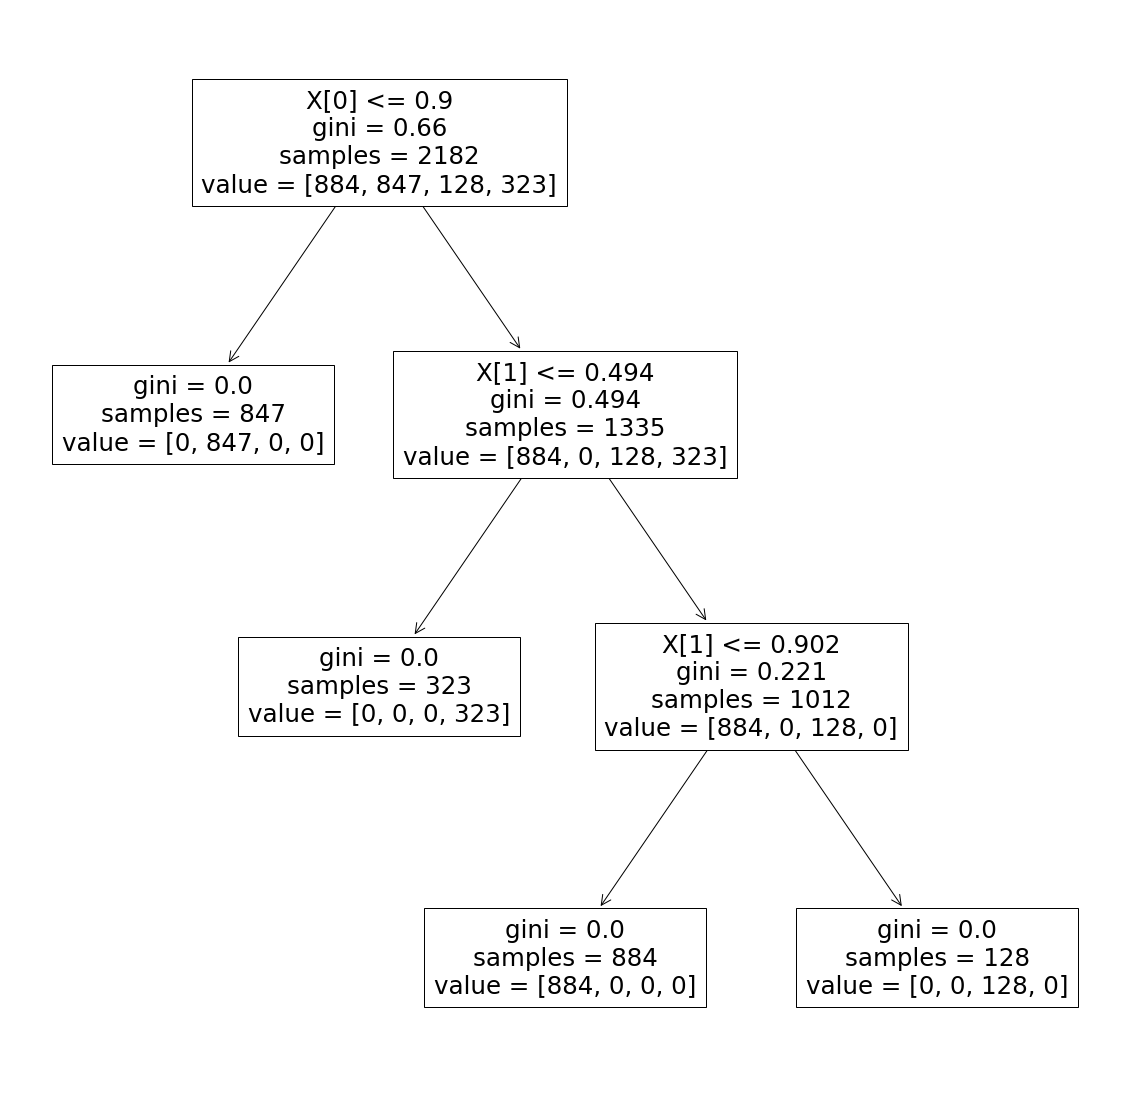

In [53]:
fig = plt.figure(figsize=(20,20))
_ = tree.plot_tree(M)

In [54]:
YF = M.predict(XT)
confusion_matrix(YT,YF)

array([[1321,    0,    0,    0],
       [   0, 1250,    0,    0],
       [   0,    0,  200,    0],
       [   0,    0,    0,  502]])